In [48]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

In [72]:
from utils import dataset_INCan
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sklearn
# normalize the features
from sklearn.preprocessing import StandardScaler
# classifiers
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
# use leave one out cross validation
from sklearn.model_selection import LeaveOneOut
# metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve

We normalize the data to have zero mean and unit variance (Standard Scaling).
- We may try other normalization?
- In practice SVM and most of the other algorithms work better if the features are normalized like this.

## Normalizing each fold or the whole data? LOO

1. The first school of thought argues that scaling data for every iteration is unnecessary and can actually be detrimental to the model's performance. This is because scaling the data for every iteration introduces additional variability into the training process, which can make it harder for the model to learn the underlying patterns in the data.
- In our case it can be the best option, because we have a small dataset.

2. The second school of thought argues that scaling data for every iteration is essential for ensuring the accuracy of the model's performance estimates. This is because LOO validation is a very sensitive method, and even small changes in the data can have a significant impact on the model's performance.
- This is more from-the-book implementation, more clean, but may add variability to our already small dataset.

# OLD Version

In [218]:
# # get X values
# features = pd.read_csv(repo_path / 'data/deep/features/features_1024/V_1_features.csv')
# # remove the first column
# features = features.iloc[:,1:]
# # get y values
# labels = dataset_INCan().labels_list(receptor='RE')
# # labels to df
# labels = pd.DataFrame(labels, columns=['label'])
# # print label distribution porcentage
# print(labels['label'].value_counts(normalize=True).values[0].round(3))

# # create the scaler
# scaler = StandardScaler()
# # fit the scaler
# scaler.fit(features)
# # transform the features
# features = pd.DataFrame(scaler.transform(features))

# # create the classifier
# clf = SVC(kernel='linear', C=0.1, gamma=0.1, probability=True)
# # create the cross validation
# loo = LeaveOneOut()
# # get the number of samples
# n_samples = len(features)
# # create the predictions list
# predictions = []
# true_labels = []
# probabilities = []
# # iterate over the samples
# for train_index, test_index in loo.split(features):
#     # get the train and test data
#     X_train, X_test = features.iloc[train_index], features.iloc[test_index]
#     # get the train and test labels
#     y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
#     # fit the model
#     clf.fit(X_train, y_train.values.ravel())
#     # predict the test sample
#     y_pred = clf.predict(X_test)
#     # predict the probability
#     y_prob = clf.predict_proba(X_test)
#     # append the prediction
#     predictions.append(y_pred)
#     probabilities.append(y_prob)
#     true_labels.append(y_test.values[0])
# # convert the predictions to array
# predictions = np.asarray(predictions)
# true_labels = np.asarray(true_labels)
# probabilities = np.asanyarray(probabilities).reshape(-1,2)[:,0]

# # compute roc
# roc_auc = roc_auc_score(true_labels, probabilities)

# # # get metrics scores
# # accuracy = accuracy_score(true_labels, predictions)
# # precision = precision_score(true_labels, predictions)
# # recall = recall_score(true_labels, predictions)
# # f1 = f1_score(true_labels, predictions)

# # # print the scores all together
# # print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}, \nROC_AUC: {roc_auc}\n')

# # # display the confusion matrix
# # cm = confusion_matrix(true_labels, predictions)
# # ConfusionMatrixDisplay(cm).plot()
# # plt.title('Confusion Matrix')

# # plot the ROC curve

# fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
# plt.figure()
# plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
# plt.plot([0,1],[0,1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# # get ideal threshold
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = thresholds[optimal_idx]
# # plot the optimal threshold
# plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best Threshold')
# plt.legend()

# # get optimal predictions
# optimal_predictions = np.where(probabilities > optimal_threshold, 1, 0)
# # get metrics scores
# accuracy = accuracy_score(true_labels, optimal_predictions)
# precision = precision_score(true_labels, optimal_predictions)
# recall = recall_score(true_labels, optimal_predictions)
# f1 = f1_score(true_labels, optimal_predictions)

# # print the scores all together
# print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}')
# # display the confusion matrix
# cm = confusion_matrix(true_labels, optimal_predictions)
# ConfusionMatrixDisplay(cm).plot()


# New Version: OO

In [66]:
# create predictor class
class predictor_machine():
    def __init__(self):
        
        self.clf = None
        self.scaler = StandardScaler()
        self.cv = LeaveOneOut()
        self.original_features = None
        self.features = None
        self.num_samples = 0
        self.receptor = None
        self.labels = None
        # lists
        self.probabilities = []
        self.true_labels = []
        self.best_estimators = []
        # budget
        self.budget = pd.read_csv(repo_path / 'data/budget/budget_std.csv', index_col=0).mean(axis=0)
        self.synthetic_units = 1
        self.X_test_augmented = None

    def set_classifier(self, pred:sklearn.base.BaseEstimator, parameters:dict, verbose:int=0):
        # grid search, the best model is selected based on the roc_auc score
        self.clf = GridSearchCV(pred, parameters, cv=3, scoring='roc_auc', verbose=verbose, n_jobs=6)

    def prepare_features(self, features:pd.DataFrame, show_info=True, scale_together=False):
        """with the defined scaler, scale feature and return as a dataframe

        Args:
            features (pd.DataFrame): input features, in order of prediction. Only numerical values.

        Returns:
            pd.DataFrame: scaled features
        """
        # ensure index is in order
        # features = features.sort_index()
        self.original_features = features.copy()
        if scale_together:
            self.scaler.fit(features)
            features = pd.DataFrame(self.scaler.transform(features))
            # show worning
            print('Features scaled together. This could represent DATA LEAKAGE.')
        self.num_samples = len(features)
        if show_info:
            print(f'Features prepared, {self.num_samples} samples, {features.shape[1]} features.')
        self.features = features

    def set_receptor(self, receptor:str, show_distribution:bool=False):
        """set the receptor to predict, it prepare the labels format

        Args:
            receptor (str): name of the receptor to predict
            show_distribution (bool, optional): show the positive distribution. Defaults to False.
        """
        self.receptor = receptor
        labels = dataset_INCan().labels_list(receptor=self.receptor)
        self.labels = pd.DataFrame(labels, columns=[self.receptor])
        if show_distribution:
            print(f'The positive cases of {self.receptor} represent {self.labels[self.receptor].mean().round(3)*100}%')  

    def train(self):
        for train_index, test_index in self.cv.split(self.features):
            # get the train and test data
            X_train, X_test = self.features.iloc[train_index], self.features.iloc[test_index]
            # scale the data
            X_train = self.scaler.fit_transform(X_train)
            X_test = self.scaler.transform(X_test)
            # get the train and test labels
            y_train, y_test = self.labels.iloc[train_index], self.labels.iloc[test_index]
            # fit the model
            self.clf.fit(X_train, y_train.values.ravel())
            # save best params of this iteration
            self.best_estimators.append(self.clf.best_estimator_)
            # predict the probability
            y_prob = self.clf.predict_proba(X_test)
            # append the prediction
            self.probabilities.append(y_prob)
            self.true_labels.append(y_test.values[0])
        # convert to arrays
        self.true_labels = np.asarray(self.true_labels)[:,0]
        self.probabilities = np.asanyarray(self.probabilities).reshape(-1,2)[:,0]

        print(f'Training finished!')

    def compute_metrics(self, plot_metrics:bool=True):
        
        roc_auc = roc_auc_score(self.true_labels, self.probabilities)
        fpr, tpr, thresholds = roc_curve(self.true_labels, self.probabilities)
        # get ideal threshold
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        # get optimal predictions
        optimal_predictions = np.where(self.probabilities > optimal_threshold, 1, 0)
        accuracy = accuracy_score(self.true_labels, optimal_predictions)
        precision = precision_score(self.true_labels, optimal_predictions)
        recall = recall_score(self.true_labels, optimal_predictions)
        f1 = f1_score(self.true_labels, optimal_predictions)
        if not plot_metrics:
            print(f'\nAUC:{roc_auc}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\n')
        if plot_metrics:
            # plot confusion matrix on the left
            fig, ax = plt.subplots(1,3, figsize=(15,5))
            cm = confusion_matrix(self.true_labels, optimal_predictions)
            ConfusionMatrixDisplay(cm).plot(ax=ax[0])
            ax[0].set_title('Confusion Matrix')
            # plot the ROC curve on the right
            ax[1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
            ax[1].plot([0,1],[0,1], 'k--')
            ax[1].set_xlabel('False Positive Rate')
            ax[1].set_ylabel('True Positive Rate')
            ax[1].set_title('ROC Curve')
            ax[1].scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label=f'Best Threshold: {optimal_threshold.round(3)}')
            ax[1].legend()
            # plot the metrics on the right, using thin bars
            ax[2].barh(['Accuracy', 'Precision', 'Recall', 'F1'], [accuracy, precision, recall, f1], height=0.5)
            # set the limits
            ax[2].set_xlim(0,1)
            ax[2].set_xticks(np.arange(0,1.1,0.1))
            # write the values on the bars
            for i, v in enumerate([accuracy, precision, recall, f1]):
                ax[2].text(v+0.01, i-0.1, f'{v.round(2)}')
                
            ax[2].set_title('Metrics')
            fig.tight_layout()
            plt.show()
            
    def dumb_inference(self):
        """infere with a feature vector of zeros"""
        # restart the lists
        self.probabilities = []
        self.true_labels = []
        # create a dumb feature vector
        dumb_features = pd.DataFrame(np.zeros((self.features.shape[0], self.features.shape[1])))
        # predict
        for _, test_index in self.cv.split(self.features):
            # get the train and test data
            X_test = dumb_features.iloc[test_index]
            y_test = self.labels.iloc[test_index]
            # predict the probability
            y_prob = self.best_estimators[test_index[0]].predict_proba(X_test)
            # append the prediction
            self.probabilities.append(y_prob)
            self.true_labels.append(y_test.values[0])
        # convert to arrays
        self.true_labels = np.asarray(self.true_labels)[:,0]
        self.probabilities = np.asanyarray(self.probabilities).reshape(-1,2)[:,0]
        print('Dumb prediction, using zero-valued feature vectors, NO training done.')

    def ordered_inference(self):
        # restart the lists
        self.probabilities = []
        self.true_labels = []
        # predict
        for _, test_index in self.cv.split(self.features):
            # get the train and test data
            X_test = self.features.iloc[test_index]
            y_test = self.labels.iloc[test_index]
            # predict the probability
            y_prob = self.best_estimators[test_index[0]].predict_proba(X_test)
            # append the prediction
            self.probabilities.append(y_prob)
            self.true_labels.append(y_test.values[0])
        # convert to arrays
        self.true_labels = np.asarray(self.true_labels)[:,0]
        self.probabilities = np.asanyarray(self.probabilities).reshape(-1,2)[:,0]
        print('Recomputed prediction, NO training done.')

    def budget_inference(self):
        # restart the lists
        self.probabilities = []
        self.true_labels = []

        # predict
        for _, test_index in self.cv.split(self.features):
                # repeat the test sample to match the number of synthetic samples
                y_test = self.labels.iloc[test_index]
                y_test_augmented = np.repeat(y_test, self.synthetic_units, axis=0)

                # generate the synthetic samples
                X_test_base = self.original_features.iloc[test_index]
                self.X_test_augmented = self.augment_test(X_test_base)

                # predict the probability
                y_prob = self.best_estimators[test_index[0]].predict_proba(self.X_test_augmented)

                # append the prediction
                self.probabilities.append(y_prob)
                self.true_labels.append(y_test_augmented)
        # convert to arrays
        self.true_labels = np.asarray(self.true_labels).reshape(-1,1)[:,0]
        self.probabilities = np.asanyarray(self.probabilities).reshape(-1,2)[:,0]
        print('Computed prediction using budge, NO training done.')

    def augment_test(self, X_test_base:pd.DataFrame):
        """given a base test set, augment it with random samples from a gaussian distribution with mean zero and std given by the budget

        Args:
            X_test_base (pd.DataFrame): base of the augmentation

        Returns:
            pd.DataFrame: augmented test set
        """
        X_test_base = pd.concat([X_test_base]*self.synthetic_units, ignore_index=True)
        # generate 1000 random samples from a gaussian distribution, mean zero and std given by the budget
        random_samples = np.random.normal(0, self.budget, size=(self.synthetic_units,1024))
        random_samples = pd.DataFrame(random_samples, columns=X_test_base.columns)
        # sum the random samples to the base features
        X_test_augmented = X_test_base + random_samples

        # scale according to scaler
        X_test_augmented = pd.DataFrame(self.scaler.transform(X_test_augmented))

        # send all the features to 0
        X_test_augmented = np.where(X_test_augmented < 0, 0, X_test_augmented)
        X_test_augmented = np.where(X_test_augmented > 0, 0, X_test_augmented)
        X_test_augmented = pd.DataFrame(X_test_augmented)

        return X_test_augmented

## One box

In [ ]:
# define the classifier
# pred = SVC(probability=True)
# parameters = {'kernel':('linear', 'rbf'), 'C':[0.01, 0.1, 1, 10], 'gamma':[0.01, 0.1, 1]}
# logistic regression

The positive cases of RP represent 63.6%
Features prepared, 33 samples, 1024 features.
Training finished!


/home/ricardo/miniconda3/envs/cedm-deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


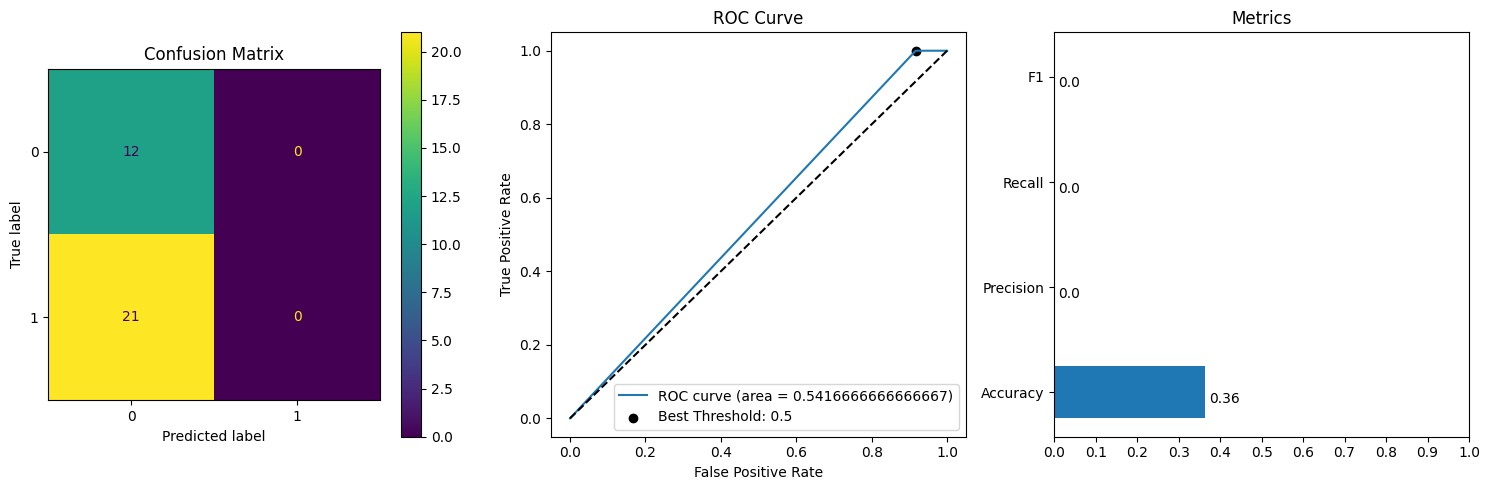

Dumb prediction, using zero-valued feature vectors, NO training done.


/home/ricardo/miniconda3/envs/cedm-deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


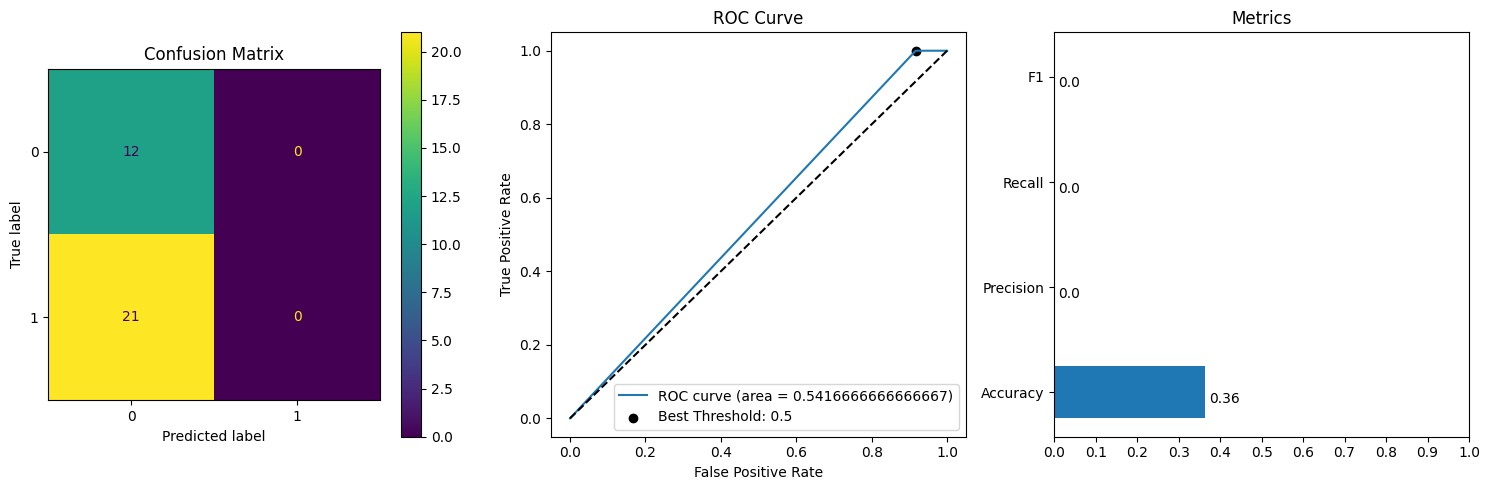

In [76]:
# Input data
receptor = 'RP'
features = pd.read_csv(repo_path / 'data/deep/features/features_1024/L_2_features.csv', index_col=0)

# prepare for the machine
predictor = predictor_machine()
predictor.set_receptor(receptor, show_distribution=True)

pred = LogisticRegression(class_weight='balanced')
parameters = {'penalty':['l1'], 'C':[0.001, 0.01, 0.1, 1, 10], 'solver':['liblinear']}
# pred = SVC(probability=True, class_weight='balanced')
# parameters = {'kernel':('linear', 'rbf'), 'C':[0.01, 0.1, 1, 10], 'gamma':[0.01, 0.1, 1]}
# random forest
# pred = RandomForestClassifier(class_weight='balanced')
# parameters = {'n_estimators':[10, 100, 1000], 'max_depth':[None, 10, 100], 'max_features':[None, 10, 100]}
# ada boost
# pred = AdaBoostClassifier()
# parameters = {'n_estimators':[10, 100, 1000], 'learning_rate':[0.01, 0.1, 1]}
predictor.set_classifier(pred, parameters, verbose=0)

predictor.prepare_features(features)
predictor.train()
predictor.compute_metrics(plot_metrics=True)
predictor.dumb_inference()
predictor.compute_metrics(plot_metrics=True)

## Multiple boxes

The positive cases represent 81.8%
Training finished!


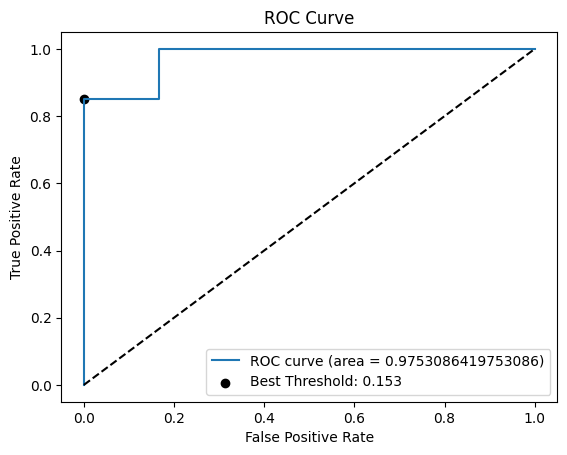

AUC:0.9753086419753086
Accuracy: 0.8484848484848485
Precision: 1.0
Recall: 0.8148148148148148
F1: 0.8979591836734693



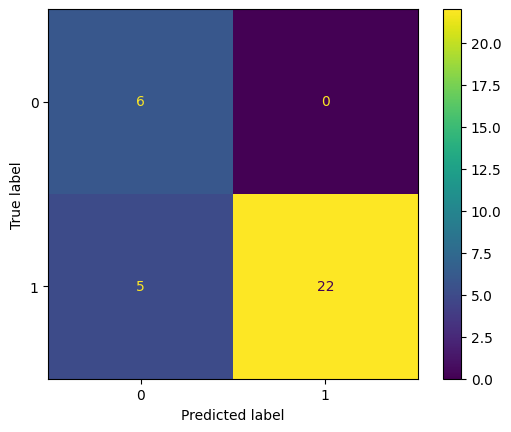

In [46]:
# prepare for the machine
predictor = predictor_machine()

# get the features
features = main_df_mean
# get the labels
predictor.set_receptor('RE', show_distribution=True)

# grid search # 0.0001 maybe too small, overfitting? linear removed in ki67 overfitting?
# parameters = {'kernel':[ 'rbf'], 'C':[0.01, 0.1, 1], 'gamma':[0.01, 0.1, 1]}
parameters = {'kernel':[ 'rbf'], 'C':[0.01, 0.1, 1], 'gamma':[0.01, 0.1, 1]} 
# define the classifier
pred = SVC(probability=True)
# define the grid search, the best model is selected based on the roc_auc score
predictor.clf = GridSearchCV(pred, parameters, cv=3, scoring='roc_auc', verbose=0, n_jobs=8)

predictor.scale_features(features)
predictor.train()
predictor.compute_metrics(plot_roc=True, plot_CM=True)

### Testing with individual rad boxes features

In [47]:
# try predicting with the individual values of the radiologists
# get mean features from radiologists
# main_df = None
for rad in ['V', 'M', 'L']:
    for time in [1,2]:
        # get the features, remove the first column (patient ID)
# rad = 'L'
# time = 1
        features = pd.read_csv(repo_path / f'data/deep/features/features_1024/{rad}_{time}_features.csv', index_col=0)

        # redefine new features and labels
        predictor.scale_features(features)
        predictor.ordered_inference()
        predictor.compute_metrics(plot_roc=False, plot_CM=False)

Recomputed prediction, NO training done.
AUC:0.9753086419753086
Accuracy: 0.8484848484848485
Precision: 1.0
Recall: 0.8148148148148148
F1: 0.8979591836734693

Recomputed prediction, NO training done.
AUC:0.9753086419753086
Accuracy: 0.8484848484848485
Precision: 1.0
Recall: 0.8148148148148148
F1: 0.8979591836734693

Recomputed prediction, NO training done.
AUC:0.9753086419753086
Accuracy: 0.8484848484848485
Precision: 1.0
Recall: 0.8148148148148148
F1: 0.8979591836734693

Recomputed prediction, NO training done.
AUC:0.9753086419753086
Accuracy: 0.8484848484848485
Precision: 1.0
Recall: 0.8148148148148148
F1: 0.8979591836734693

Recomputed prediction, NO training done.
AUC:0.9753086419753086
Accuracy: 0.8484848484848485
Precision: 1.0
Recall: 0.8148148148148148
F1: 0.8979591836734693

Recomputed prediction, NO training done.
AUC:0.9753086419753086
Accuracy: 0.8484848484848485
Precision: 1.0
Recall: 0.8148148148148148
F1: 0.8979591836734693



### Testing with budget

Computed prediction using budge, NO training done.


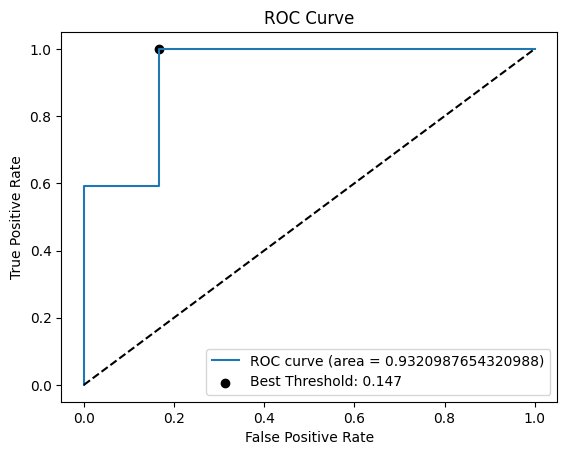

AUC:0.9320987654320988
Accuracy: 0.9393939393939394
Precision: 0.9629629629629629
Recall: 0.9629629629629629
F1: 0.9629629629629629



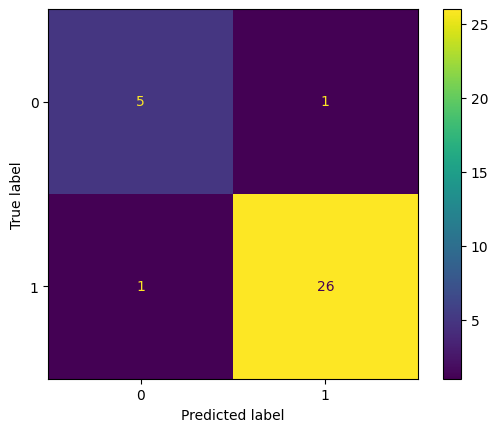

In [49]:
predictor.budget_inference()
predictor.compute_metrics(plot_roc=True, plot_CM=True)

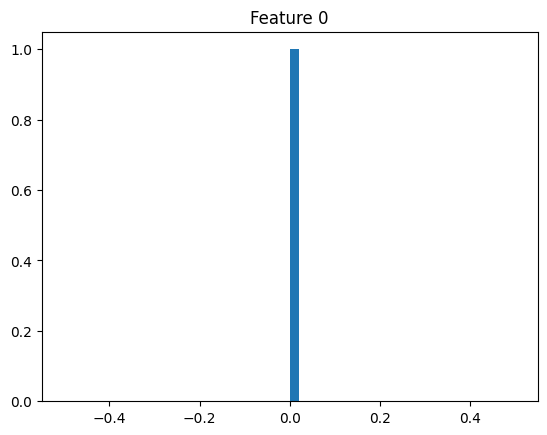

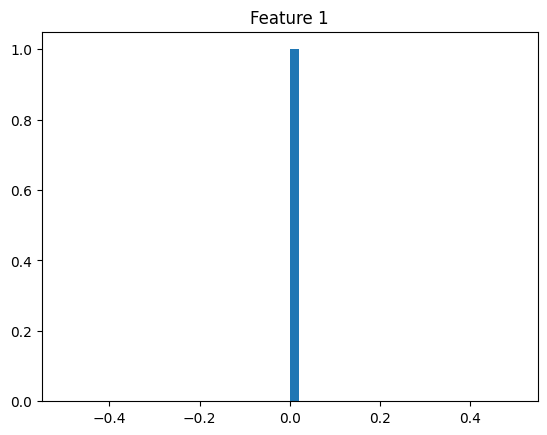

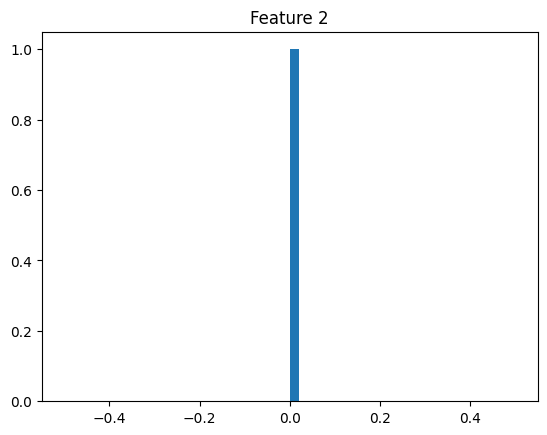

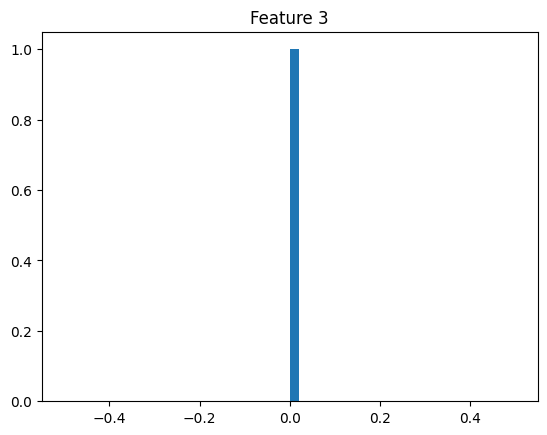

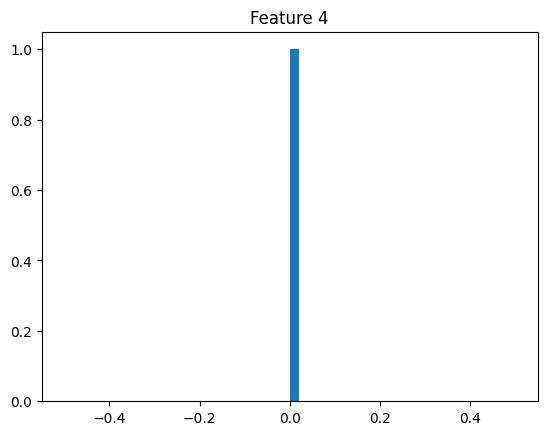

In [50]:
feature_ex = predictor.X_test_augmented
# plot the distribution of the features
for i in range(5):
    plt.figure()
    plt.hist(feature_ex.iloc[:,-i], bins=50)
    plt.title(f'Feature {i}')
    plt.show()